In [6]:
import QuantLib as ql
import numpy as np
from timeit import default_timer as timer

# option data
calculation_date = ql.Date(27, 10, 2019)
maturity_date = ql.Date(30, 10, 2020)
stock_price = ql.SimpleQuote(150.0)
strike_price = 150.0
volatility = ql.SimpleQuote(0.10) # the historical vols for a year
dividend_rate =  ql.SimpleQuote(0.002)
risk_free_rate = ql.SimpleQuote(0.003)
option_type = ql.Option.Put
barrier = 160.0
barrier_type = ql.Barrier.UpOut
rebate = 0.0

day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

ql.Settings.instance().evaluationDate = calculation_date

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

spot_handle = ql.QuoteHandle(stock_price)
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, ql.QuoteHandle(risk_free_rate), day_count))
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, ql.QuoteHandle(dividend_rate), day_count))
flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, ql.QuoteHandle(volatility), day_count))
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)


In [7]:
option = ql.BarrierOption(barrier_type, barrier, rebate, 
                       payoff, 
                       ql.EuropeanExercise(maturity_date))
option.setPricingEngine(ql.AnalyticBarrierEngine(bsm_process))
trueValue = option.NPV()

print("The theoretical price is ", trueValue)

The theoretical price is  5.2214083456793166


In [8]:
#variable names need to be changed

class BarrierOption:
    def __init__(self, calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type, barrier, barrier_type, rebate):
        self.maturity = maturity
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.dividend_rate = dividend_rate
        self.risk_free_rate = risk_free_rate
        self.option_type = option_type
        self.calculation_date = calculation_date
        self.barrier = barrier
        self.barrier_type = barrier_type
        self.rebate = rebate
        self.bs_price = -1
        
        
    def BSM_price(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, ql.QuoteHandle(ql.SimpleQuote(self.risk_free_rate)), day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, ql.QuoteHandle(ql.SimpleQuote(self.dividend_rate)), day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, ql.QuoteHandle(ql.SimpleQuote(self.volatility)), day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        option = ql.BarrierOption(self.barrier_type, self.barrier, self.rebate, 
                       payoff, exercise)
        option.setPricingEngine(ql.AnalyticBarrierEngine(bsm_process))
        trueValue = option.NPV()
        self.bs_price = trueValue
        return self.bs_price
    
    def data_set(self):
        '''
        Funtion to return a set of required data for one sample for training purpose.
        
        '''
        if self.bs_price == -1:
            self.BSM_price()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        data_set = (self.stock_price, self.strike_price,self.barrier, maturity_in_year, self.dividend_rate, self.volatility, self.risk_free_rate, self.rebate, self.bs_price)
        return data_set

In [9]:
stock_price = 150.0
barrier_price = 160.0
rebate = 0.0
volatility = 0.1
risk_free_rate = 0.003
dividend_rate = 0.002
barrier = BarrierOption(calculation_date, maturity_date, stock_price, strike_price, volatility, 
                        dividend_rate, risk_free_rate, option_type, barrier_price, barrier_type, rebate
                        )
print('barrier price: ', barrier.BSM_price())

barrier price:  5.2214083456793166


In [10]:
from statistics import *
from math import sqrt
import matplotlib as mpl
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats


In [15]:
import datetime
import random
import pandas as pd

'''Date helper functions'''
def xldate_to_datetime(xldate):
    temp = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

def datetime_to_xldate(date):
    temp = datetime.datetime(1899, 12, 30)
    return (date - temp).days

def random_barrier_options_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Put
        barrier_price = stock_price * (random.uniform(1, 1.2))
        barrier_type = ql.Barrier.UpOut
        rebate = 0.0
        option = BarrierOption(calculation_date, maturity, stock_price, strike_price, volatility, 
                        dividend_rate, risk_free_rate, option_type, barrier_price, barrier_type, rebate
                        )
        options.append(option.data_set())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'barrier_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'rebate', 'put_price']
    return dataframe

def random_barrier_options_uniform_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    
    numbers = 9
    maturity = np.linspace(xldate1, xldate2+1, 10)
    stock_price = np.linspace(100, 500, 10)
    strike_price = np.linspace(7, 650, 10)
    volatility = np.linspace(0.05, 0.90, 10)
    dividend_rate = np.linspace(0, 0.003, 10)
    risk_free_rate = np.linspace(0.001, 0.003, 10)
    option_type = ql.Option.Put
    barrier_price = stock_price * (random.uniform(1.01, 1.2))
    barrier_type = ql.Barrier.UpOut
    rebate = 0.0

    for i in range(numbers):
        for j in range(numbers):
            for k in range(numbers):
                for l in range(numbers):
                    for m in range(numbers):
                        for n in range(numbers):
                            for o in range(numbers):
                                option = BarrierOption(calculation_date, ql.Date(int(maturity[i])), stock_price[j], strike_price[k], volatility[l], dividend_rate[m], 
                                            risk_free_rate[n], option_type, barrier_price[o],barrier_type, rebate )
                                options.append(option.data_set()) 
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'barrier_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'put_price']
    return dataframe


In [17]:
df = random_barrier_options_pd(1000000)
df = df.sample(frac=1).reset_index(drop=True)
df.to_pickle('barrier_option_random.pkl')

In [44]:
from sklearn.preprocessing import MinMaxScaler
n = 1000000
df = pd.read_pickle('barrier_option_random.pkl')
n_train =  (int)(0.8 * n)
train = df[0:n_train]
test = df[n_train+1:n]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_training = scaler.fit_transform(train)
scaled_testing = scaler.transform(test)
scaled_training_df = pd.DataFrame(scaled_training,columns=train.columns.values)
scaled_testing_df = pd.DataFrame(scaled_testing,columns=test.columns.values)

print("mutiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[6],scaler.min_[6]))
X_train = scaled_training_df[['stock_price','strike_price', 'barrier_price','maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_train = scaled_training_df['put_price'].values
X_test = scaled_testing_df[['stock_price', 'strike_price','barrier_price','maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_test = scaled_testing_df['put_price'].values

mutiplying by 500.0010732744 and adding -0.500001


In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import keras

model = Sequential()
model.add(Dense(50,input_dim=7,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

'''
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=3,
        verbose=1)
]
'''

model.fit(X_train, y_train, epochs=20, validation_split=0.2,
        shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))


Using TensorFlow backend.


Train on 640000 samples, validate on 160000 samples
Epoch 1/20
 - 47s - loss: 5.0173e-04 - val_loss: 3.8861e-04
Epoch 2/20
 - 57s - loss: 1.6248e-04 - val_loss: 4.5759e-05
Epoch 3/20
 - 66s - loss: 9.8775e-05 - val_loss: 3.9784e-05
Epoch 4/20
 - 61s - loss: 7.8671e-05 - val_loss: 6.0682e-05
Epoch 5/20
 - 67s - loss: 6.3749e-05 - val_loss: 2.6364e-05
Epoch 6/20
 - 63s - loss: 6.0319e-05 - val_loss: 4.2312e-05
Epoch 7/20
 - 51s - loss: 5.5422e-05 - val_loss: 1.0737e-04
Epoch 8/20
 - 49s - loss: 4.1650e-05 - val_loss: 2.4020e-05
Epoch 9/20
 - 45s - loss: 4.2168e-05 - val_loss: 1.2141e-04
Epoch 10/20
 - 48s - loss: 3.8724e-05 - val_loss: 8.0714e-06
Epoch 11/20
 - 44s - loss: 3.7481e-05 - val_loss: 1.2024e-05
Epoch 12/20
 - 68s - loss: 3.3348e-05 - val_loss: 2.3542e-05
Epoch 13/20
 - 48s - loss: 3.3703e-05 - val_loss: 9.4753e-06
Epoch 14/20
 - 62s - loss: 3.1452e-05 - val_loss: 1.0383e-05
Epoch 15/20
 - 55s - loss: 3.0552e-05 - val_loss: 2.1581e-05
Epoch 16/20
 - 47s - loss: 2.6962e-05 - va

NameError: name 'loaded_model' is not defined

Mean Squared Error:       6.446988014813182e-06
Root Mean Squared Error:  0.002539091966592227
Mean Absolute Error:      0.0013736171431808159
Mean Percent Error:       0.034781779882345015


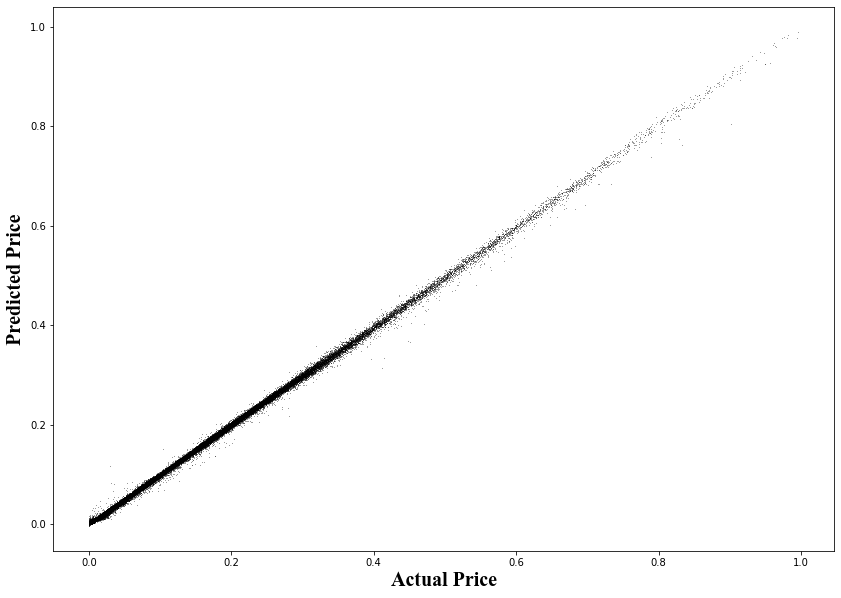

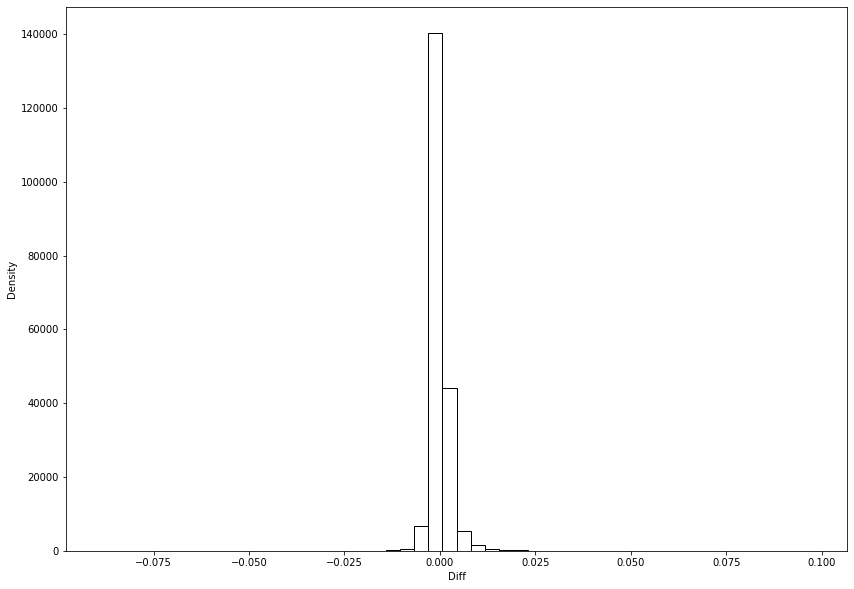

In [24]:
y_test_hat = model.predict(X_test)
y_test_hat = np.squeeze(y_test_hat)
CheckAccuracy(y_test, y_test_hat)

In [45]:
df = random_barrier_options_pd(1)

def DL_prediction_scaled(scaler, model, df):
    scaled_training = scaler.transform(df)
    input_df = pd.DataFrame(scaled_training,columns=df.columns.values)
    greek_input = input_df[['stock_price','strike_price', 'barrier_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    nn_original_price = model.predict(greek_input)[0][0] 
    return nn_original_price


## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K

bo_price = DL_prediction_scaled(scaler, model, df)
print('prediction price: ', (bo_price - scaler.min_[6])/scaler.scale_[6])
print('original price: ', df['put_price'].values )

prediction price:  0.0011333680315330625
original price:  [36.23780907]
